In [1]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [2]:
DF = pd.read_csv('finalData.csv').drop(['Unnamed: 0.1'],axis=1).drop(['Unnamed: 0'],axis=1)
DF=DF.rename(columns = {'Vehicle Type':'vehicleType'})

,Year,Mileage,City,State,vehicleType,serviceTime,DepreciationRate,Gdp,Population
0,2012,94887,DALLAS,TX,SUV,6,0.841505,535499,1359133
1,2014,55194,DALLAS,TX,Sedan,4,0.458779,535499,1359133
2,2015,38627,DALLAS,TX,SUV,3,0.567258,535499,1359133
3,2013,116573,DALLAS,TX,Sedan,5,0.394357,535499,1359133
4,2006,173165,DALLAS,TX,Truck,12,0.392006,535499,1359133
5,2014,36579,DALLAS,TX,Sedan,4,0.582090,535499,1359133
6,2013,38219,DALLAS,TX,Sedan,5,0.545941,535499,1359133
7,2014,113868,DALLAS,TX,Truck,4,0.569834,535499,1359133
8,2017,17998,DALLAS,TX,Sedan,1,0.800692,535499,1359133
9,2014,29230,DALLAS,TX,Sedan,4,0.535148,535499,1359133


In [3]:
#a list of variables excluding dummy variable
XVariable = ['Gdp', 'Population', 'serviceTime', 'Mileage']

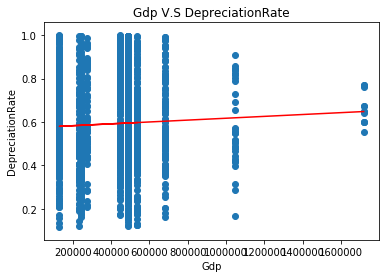

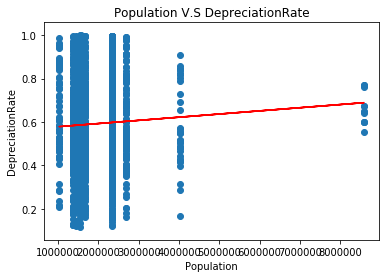

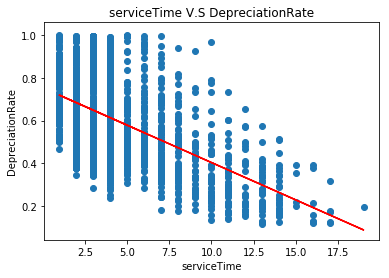

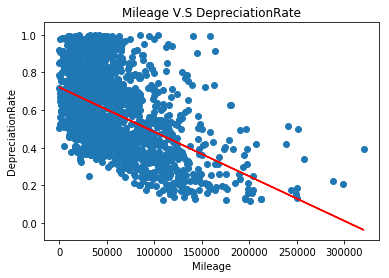

In [4]:
Y = DF["DepreciationRate"]
for variable in XVariable:
    X = DF[variable]
    slope, intercept, r_value, p_value, std_err = stats.linregress(X,Y)

    plt.scatter(X, Y)
    yfit = [intercept + slope * xi for xi in X]
    plt.plot(X, yfit,c='r')
    plt.xlabel(variable)
    plt.ylabel("DepreciationRate")
    plt.title(variable + " V.S DepreciationRate")
    plt.show()

In [5]:
lm = smf.ols('DepreciationRate ~ C(vehicleType)+Gdp+Population+serviceTime+Mileage', data=DF).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:       DepreciationRate   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     438.9
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:42:57   Log-Likelihood:                 1136.5
No. Observations:                1906   AIC:                            -2259.
Df Residuals:                    1899   BIC:                            -2220.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

In [6]:
lm2 = smf.ols('DepreciationRate ~ C(vehicleType)+serviceTime+Mileage', data=DF).fit()
print(lm2.summary())

                            OLS Regression Results                            
Dep. Variable:       DepreciationRate   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     658.3
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:42:59   Log-Likelihood:                 1135.9
No. Observations:                1906   AIC:                            -2262.
Df Residuals:                    1901   BIC:                            -2234.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

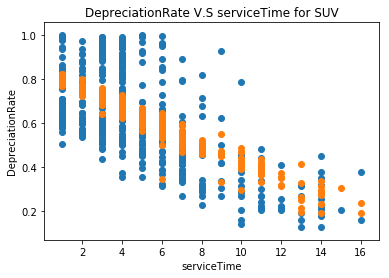

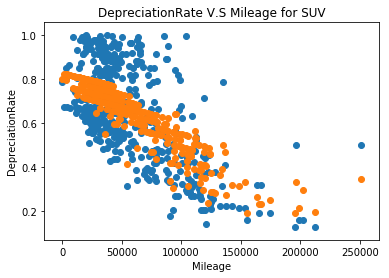

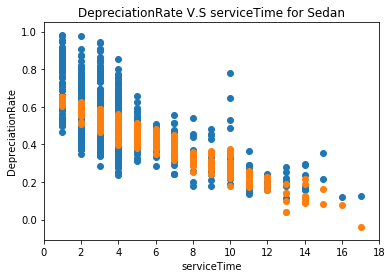

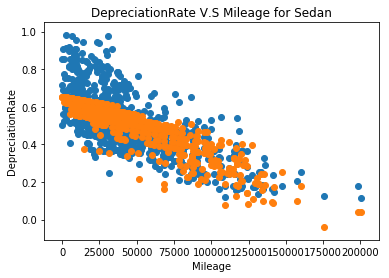

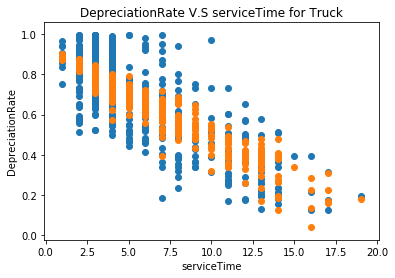

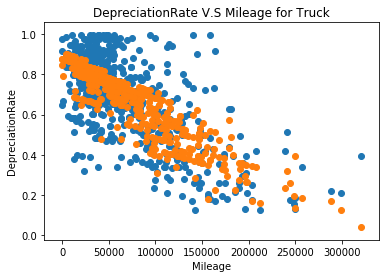

In [7]:
DF['Prediction'] = lm2.predict()
plt.scatter(DF.query('vehicleType == \'SUV\'').serviceTime, DF.query('vehicleType == \'SUV\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'SUV\'').serviceTime, DF.query('vehicleType == \'SUV\'').Prediction)
plt.xlabel('serviceTime')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S serviceTime for SUV')
plt.show()
plt.scatter(DF.query('vehicleType == \'SUV\'').Mileage, DF.query('vehicleType == \'SUV\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'SUV\'').Mileage, DF.query('vehicleType == \'SUV\'').Prediction)
plt.xlabel('Mileage')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S Mileage for SUV')
plt.show()
plt.scatter(DF.query('vehicleType == \'Sedan\'').serviceTime, DF.query('vehicleType == \'Sedan\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'Sedan\'').serviceTime, DF.query('vehicleType == \'Sedan\'').Prediction)
plt.xlabel('serviceTime')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S serviceTime for Sedan')
plt.show()
plt.scatter(DF.query('vehicleType == \'Sedan\'').Mileage, DF.query('vehicleType == \'Sedan\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'Sedan\'').Mileage, DF.query('vehicleType == \'Sedan\'').Prediction)
plt.xlabel('Mileage')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S Mileage for Sedan')
plt.show()
plt.scatter(DF.query('vehicleType == \'Truck\'').serviceTime, DF.query('vehicleType == \'Truck\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'Truck\'').serviceTime, DF.query('vehicleType == \'Truck\'').Prediction)
plt.xlabel('serviceTime')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S serviceTime for Truck')
plt.show()
plt.scatter(DF.query('vehicleType == \'Truck\'').Mileage, DF.query('vehicleType == \'Truck\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'Truck\'').Mileage, DF.query('vehicleType == \'Truck\'').Prediction)
plt.xlabel('Mileage')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S Mileage for Truck')
plt.show()

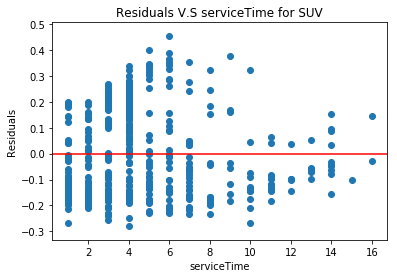

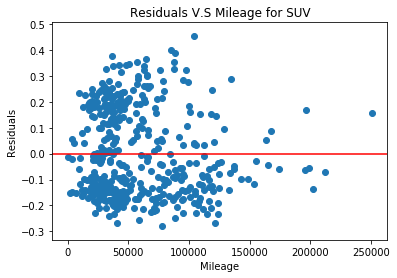

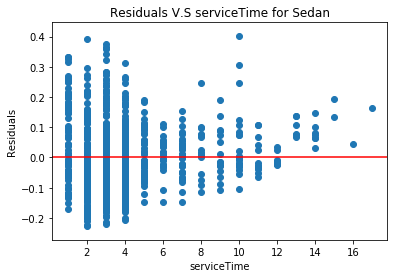

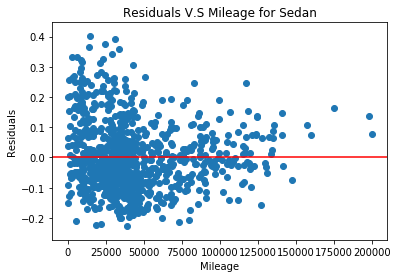

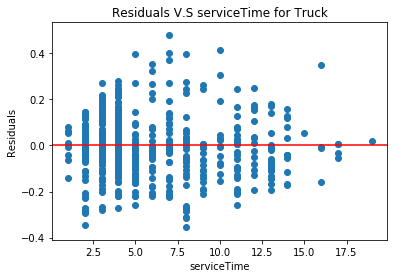

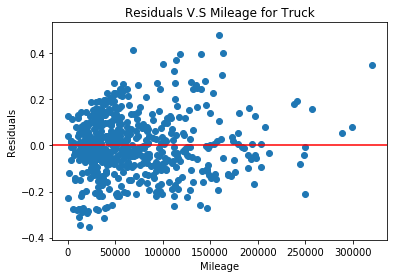

In [8]:
plt.scatter(DF.query('vehicleType == \'SUV\'').serviceTime, DF.query('vehicleType == \'SUV\'').DepreciationRate-DF.query('vehicleType == \'SUV\'').Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('serviceTime')
plt.ylabel('Residuals')
plt.title('Residuals V.S serviceTime for SUV')
plt.show()
plt.scatter(DF.query('vehicleType == \'SUV\'').Mileage, DF.query('vehicleType == \'SUV\'').DepreciationRate-DF.query('vehicleType == \'SUV\'').Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Mileage')
plt.ylabel('Residuals')
plt.title('Residuals V.S Mileage for SUV')
plt.show()
plt.scatter(DF.query('vehicleType ==\'Sedan\'').serviceTime, DF.query('vehicleType == \'Sedan\'').DepreciationRate-DF.query('vehicleType == \'Sedan\'').Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('serviceTime')
plt.ylabel('Residuals')
plt.title('Residuals V.S serviceTime for Sedan')
plt.show()
plt.scatter(DF.query('vehicleType == \'Sedan\'').Mileage, DF.query('vehicleType == \'Sedan\'').DepreciationRate-DF.query('vehicleType == \'Sedan\'').Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Mileage')
plt.ylabel('Residuals')
plt.title('Residuals V.S Mileage for Sedan')
plt.show()
plt.scatter(DF.query('vehicleType == \'Truck\'').serviceTime, DF.query('vehicleType == \'Truck\'').DepreciationRate-DF.query('vehicleType == \'Truck\'').Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('serviceTime')
plt.ylabel('Residuals')
plt.title('Residuals V.S serviceTime for Truck')
plt.show()
plt.scatter(DF.query('vehicleType == \'Truck\'').Mileage, DF.query('vehicleType == \'Truck\'').DepreciationRate-DF.query('vehicleType == \'Truck\'').Prediction)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Mileage')
plt.ylabel('Residuals')
plt.title('Residuals V.S Mileage for Truck')
plt.show()

In [9]:
DF['logMileage'] = np.log(1/DF['Mileage'])
lm3 = smf.ols("DepreciationRate ~ C(vehicleType)+serviceTime+Mileage+logMileage", data=DF).fit()
print(lm3.summary())

                            OLS Regression Results                            
Dep. Variable:       DepreciationRate   R-squared:                       0.582
Model:                            OLS   Adj. R-squared:                  0.581
Method:                 Least Squares   F-statistic:                     529.8
Date:                Tue, 04 Dec 2018   Prob (F-statistic):               0.00
Time:                        14:43:21   Log-Likelihood:                 1139.5
No. Observations:                1906   AIC:                            -2267.
Df Residuals:                    1900   BIC:                            -2234.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

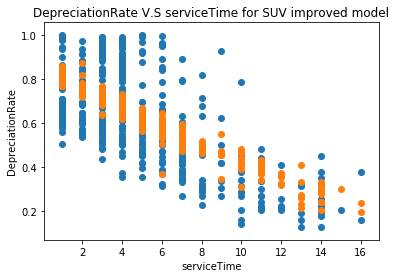

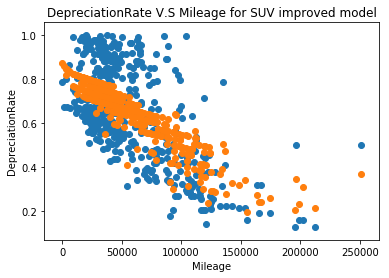

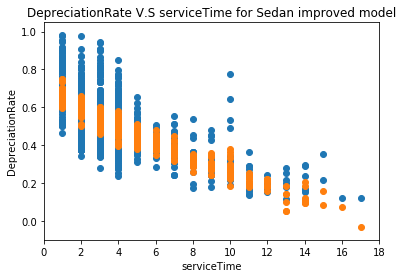

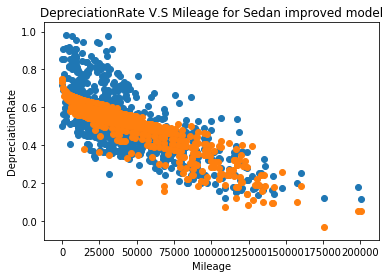

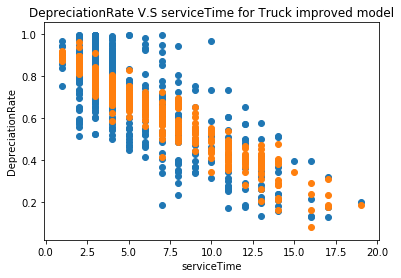

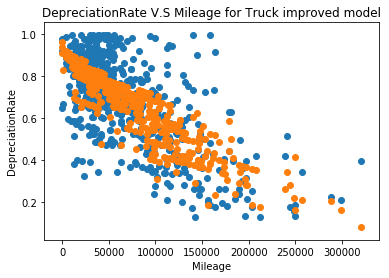

In [10]:
DF['Prediction3'] = lm3.predict()
plt.scatter(DF.query('vehicleType == \'SUV\'').serviceTime, DF.query('vehicleType == \'SUV\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'SUV\'').serviceTime, DF.query('vehicleType == \'SUV\'').Prediction3)
plt.xlabel('serviceTime')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S serviceTime for SUV improved model')
plt.show()
plt.scatter(DF.query('vehicleType == \'SUV\'').Mileage, DF.query('vehicleType == \'SUV\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'SUV\'').Mileage, DF.query('vehicleType == \'SUV\'').Prediction3)
plt.xlabel('Mileage')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S Mileage for SUV improved model')
plt.show()
plt.scatter(DF.query('vehicleType == \'Sedan\'').serviceTime, DF.query('vehicleType == \'Sedan\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'Sedan\'').serviceTime, DF.query('vehicleType == \'Sedan\'').Prediction3)
plt.xlabel('serviceTime')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S serviceTime for Sedan improved model')
plt.show()
plt.scatter(DF.query('vehicleType == \'Sedan\'').Mileage, DF.query('vehicleType == \'Sedan\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'Sedan\'').Mileage, DF.query('vehicleType == \'Sedan\'').Prediction3)
plt.xlabel('Mileage')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S Mileage for Sedan improved model')
plt.show()
plt.scatter(DF.query('vehicleType == \'Truck\'').serviceTime, DF.query('vehicleType == \'Truck\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'Truck\'').serviceTime, DF.query('vehicleType == \'Truck\'').Prediction3)
plt.xlabel('serviceTime')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S serviceTime for Truck improved model')
plt.show()
plt.scatter(DF.query('vehicleType == \'Truck\'').Mileage, DF.query('vehicleType == \'Truck\'').DepreciationRate)
plt.scatter(DF.query('vehicleType == \'Truck\'').Mileage, DF.query('vehicleType == \'Truck\'').Prediction3)
plt.xlabel('Mileage')
plt.ylabel('DepreciationRate')
plt.title('DepreciationRate V.S Mileage for Truck improved model')
plt.show()

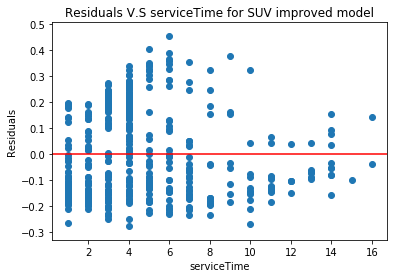

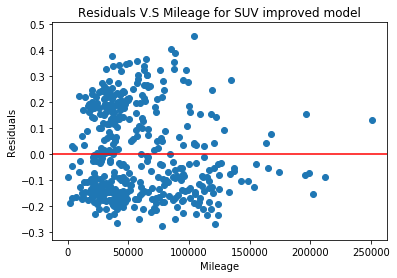

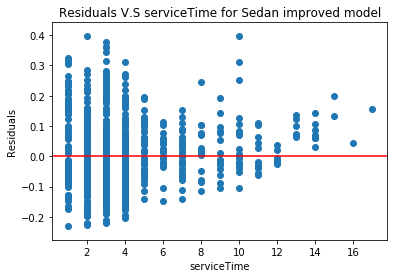

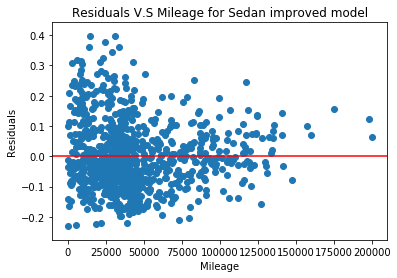

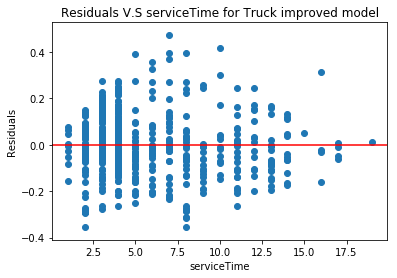

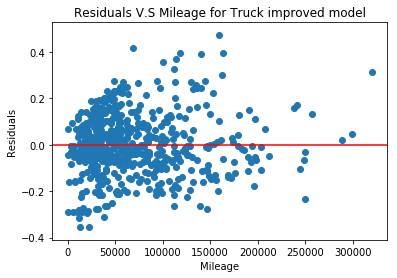

In [11]:
plt.scatter(DF.query('vehicleType == \'SUV\'').serviceTime, DF.query('vehicleType == \'SUV\'').DepreciationRate-DF.query('vehicleType == \'SUV\'').Prediction3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('serviceTime')
plt.ylabel('Residuals')
plt.title('Residuals V.S serviceTime for SUV improved model')
plt.show()
plt.scatter(DF.query('vehicleType == \'SUV\'').Mileage, DF.query('vehicleType == \'SUV\'').DepreciationRate-DF.query('vehicleType == \'SUV\'').Prediction3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Mileage')
plt.ylabel('Residuals')
plt.title('Residuals V.S Mileage for SUV improved model')
plt.show()
plt.scatter(DF.query('vehicleType ==\'Sedan\'').serviceTime, DF.query('vehicleType == \'Sedan\'').DepreciationRate-DF.query('vehicleType == \'Sedan\'').Prediction3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('serviceTime')
plt.ylabel('Residuals')
plt.title('Residuals V.S serviceTime for Sedan improved model')
plt.show()
plt.scatter(DF.query('vehicleType == \'Sedan\'').Mileage, DF.query('vehicleType == \'Sedan\'').DepreciationRate-DF.query('vehicleType == \'Sedan\'').Prediction3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Mileage')
plt.ylabel('Residuals')
plt.title('Residuals V.S Mileage for Sedan improved model')
plt.show()
plt.scatter(DF.query('vehicleType == \'Truck\'').serviceTime, DF.query('vehicleType == \'Truck\'').DepreciationRate-DF.query('vehicleType == \'Truck\'').Prediction3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('serviceTime')
plt.ylabel('Residuals')
plt.title('Residuals V.S serviceTime for Truck improved model')
plt.show()
plt.scatter(DF.query('vehicleType == \'Truck\'').Mileage, DF.query('vehicleType == \'Truck\'').DepreciationRate-DF.query('vehicleType == \'Truck\'').Prediction3)
plt.axhline(y=0, color='r', linestyle='-')
plt.xlabel('Mileage')
plt.ylabel('Residuals')
plt.title('Residuals V.S Mileage for Truck improved model')
plt.show()

In [12]:
(DF.query('vehicleType == \'Sedan\'').DepreciationRate-DF.query('vehicleType == \'Sedan\'').Prediction3).sum() 

2.0923160981567435e-09

In [13]:
(DF.query('vehicleType == \'Sedan\'').DepreciationRate-DF.query('vehicleType == \'Sedan\'').Prediction).sum()

4.037272427481753e-08

In [14]:
(DF.query('vehicleType == \'Sedan\'').DepreciationRate-DF.query('vehicleType == \'Sedan\'').Prediction3).sum() < (DF.query('vehicleType == \'Sedan\'').DepreciationRate-DF.query('vehicleType == \'Sedan\'').Prediction).sum()

True

In [15]:
(DF.query('vehicleType == \'SUV\'').DepreciationRate-DF.query('vehicleType == \'SUV\'').Prediction3).sum()

1.0235876590769521e-09

In [16]:
(DF.query('vehicleType == \'SUV\'').DepreciationRate-DF.query('vehicleType == \'SUV\'').Prediction).sum()

2.6263965668960054e-08

In [17]:
(DF.query('vehicleType == \'SUV\'').DepreciationRate-DF.query('vehicleType == \'SUV\'').Prediction3).sum() < (DF.query('vehicleType == \'SUV\'').DepreciationRate-DF.query('vehicleType == \'SUV\'').Prediction).sum()

True

In [18]:
(DF.query('vehicleType == \'Truck\'').DepreciationRate-DF.query('vehicleType == \'Truck\'').Prediction3).sum()

1.3636796136751173e-09

In [19]:
(DF.query('vehicleType == \'Truck\'').DepreciationRate-DF.query('vehicleType == \'Truck\'').Prediction).sum()

4.170491241239915e-08

In [20]:
(DF.query('vehicleType == \'Truck\'').DepreciationRate-DF.query('vehicleType == \'Truck\'').Prediction3).sum()<(DF.query('vehicleType == \'Truck\'').DepreciationRate-DF.query('vehicleType == \'Truck\'').Prediction).sum()

True